In [1324]:
import Quandl
import numpy as np
from scipy import stats
import statsmodels
import statsmodels.api as sm
from matplotlib import pyplot as plt
import itertools
%matplotlib inline
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.diagnostic import het_white, het_breushpagan
from statsmodels.tsa.stattools import coint, adfuller

In [1325]:
QUANDL_API_KEY = 'MNJzKfdjWBuixA5t61h1'

def get_quandl_data(code):
    return Quandl.get(code, authtoken=QUANDL_API_KEY)

In [1326]:
def check_for_stationarity(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
        return True
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')
        return False

### [Number of new utility patents](https://www.quandl.com/data/USPTO/PAT_ACT-U-S-Patent-Activity)

In [1327]:
patents = get_quandl_data("USPTO/PAT_ACT")
patents = patents['Utility Patents']

In [1328]:
patent_growth = patents.cumsum().pct_change()

In [1329]:
patent_growth.head()

Year
1790-12-31          NaN
1791-12-31    11.000000
1792-12-31     0.305556
1793-12-31     0.425532
1794-12-31     0.328358
Name: Utility Patents, dtype: float64

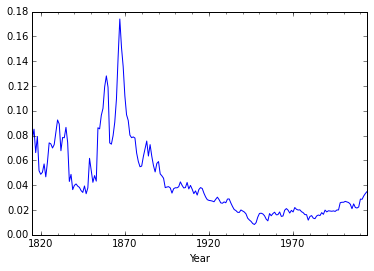

In [1330]:
patent_growth[-200:].plot()

In [1331]:
check_for_stationarity(patent_growth[-200:])

p-value = 0.355535878157 The series Utility Patents is likely non-stationary.


False

### [Natural resource rents as a percentage of GDP](https://www.quandl.com/data/WWDI/USA_NY_GDP_TOTL_RT_ZS-Total-natural-resources-rents-of-GDP-United-States)

In [1332]:
natural_resources = get_quandl_data("WWDI/USA_NY_GDP_TOTL_RT_ZS")['Value']
natural_resources.name = 'Natural Resources'
# natural_resources /= 100
natural_resources = natural_resources.pct_change()

In [1333]:
natural_resources.head()

Date
1970-12-31         NaN
1971-12-31    0.034829
1972-12-31   -0.054660
1973-12-31    0.322839
1974-12-31    1.743516
Name: Natural Resources, dtype: float64

### [Government R&D investment](https://fred.stlouisfed.org/series/Y057RA3A086NBEA)

In [1334]:
# rd_public = pd.read_csv('rd_public.csv', index_col='DATE', parse_dates=True)['Y057RA3A086NBEA']
rd_public = get_quandl_data('FRED/Y057RL1A225NBEA')['VALUE']
rd_public.name = 'R&D Public'
rd_public = rd_public.resample('A').first()
rd_public /= 100

In [1335]:
rd_public.head(), rd_public.tail()

(DATE
 1930-12-31    0.367
 1931-12-31    0.203
 1932-12-31    0.259
 1933-12-31   -0.031
 1934-12-31   -0.151
 Freq: A-DEC, Name: R&D Public, dtype: float64, DATE
 2011-12-31   -0.011
 2012-12-31   -0.036
 2013-12-31   -0.022
 2014-12-31   -0.041
 2015-12-31   -0.005
 Freq: A-DEC, Name: R&D Public, dtype: float64)

### [Private R&D investment](https://fred.stlouisfed.org/series/Y006RA3A086NBEA)

In [1336]:
# rd_private = pd.read_csv('rd_private.csv', index_col='DATE', parse_dates=True)['Y006RA3A086NBEA']
rd_private = get_quandl_data('FRED/Y006RL1A225NBEA')['VALUE']
rd_private.name = 'R&D Private'
rd_private = rd_private.resample('A').first()
rd_private /= 100

In [1337]:
rd_private.head(), rd_private.tail()

(DATE
 1930-12-31    0.110
 1931-12-31    0.210
 1932-12-31   -0.003
 1933-12-31    0.013
 1934-12-31    0.137
 Freq: A-DEC, Name: R&D Private, dtype: float64, DATE
 2011-12-31    0.010
 2012-12-31    0.026
 2013-12-31    0.046
 2014-12-31    0.028
 2015-12-31    0.035
 Freq: A-DEC, Name: R&D Private, dtype: float64)

### [Number of doctorates](https://www.quandl.com/data/NSF/DOCTORATES--Doctorate-Recipients-from-U-S-Colleges-and-Universities)

In [1338]:
doctorates = get_quandl_data("NSF/DOCTORATES")['Number']
doctorates.name = '# of Doctorates'
doctorates = doctorates.shift(-1, freq='D')
doctorates = doctorates.pct_change()

In [1339]:
doctorates.head()

Year
1956-12-31         NaN
1957-12-31    0.018813
1958-12-31    0.050154
1959-12-31    0.056442
1960-12-31    0.069865
Freq: A-DEC, Name: # of Doctorates, dtype: float64

### [Number of venture capital deals](https://www.quandl.com/data/NVCA/VENTURE_3_11-Venture-Capital-Investments-By-State-Number-of-Deals)

In [1340]:
venture_capital = get_quandl_data("NVCA/VENTURE_3_11")['Total']
venture_capital.name = '# of VC Deals'
venture_capital = venture_capital.pct_change()

In [1341]:
venture_capital.head()

Year
1985-12-31         NaN
1986-12-31    0.056506
1987-12-31    0.158339
1988-12-31   -0.072904
1989-12-31    0.011796
Name: # of VC Deals, dtype: float64

### [Unemployment rate](https://www.quandl.com/data/FRED/UNRATE-Civilian-Unemployment-Rate)

In [1342]:
unemployment = get_quandl_data("FRED/UNRATE")['VALUE']
unemployment = unemployment.shift(-1, freq='D')
unemployment = unemployment.resample('A').first()
unemployment.name = "Unemployment rate (%)"
unemployment /= 100

In [1343]:
unemployment.head()

DATE
1947-12-31    0.034
1948-12-31    0.038
1949-12-31    0.047
1950-12-31    0.064
1951-12-31    0.034
Freq: A-DEC, Name: Unemployment rate (%), dtype: float64

### [Immigration](http://www.migrationpolicy.org/programs/data-hub/charts/immigrant-population-over-time?width=1000&height=850&iframe=true)

In [1344]:
immigration = pd.read_csv('us_immigration.csv', index_col='Year', thousands=',', parse_dates=True)['Number of Legal Permanent Residents']
immigration.name = 'New Legal Permanent Residents'
immigration = immigration.shift(-1, freq='D')
immigration = immigration.pct_change()

In [1345]:
immigration.head()

Year
1819-12-31         NaN
1820-12-31    0.088491
1821-12-31   -0.242796
1822-12-31   -0.080596
1823-12-31    0.245200
Freq: A-DEC, Name: New Legal Permanent Residents, dtype: float64

### [Inflation](https://www.quandl.com/data/WORLDBANK/USA_FP_CPI_TOTL_ZG-United-States-Inflation-consumer-prices-annual)

In [1346]:
cpi = get_quandl_data('WORLDBANK/USA_FP_CPI_TOTL_ZG')['Value']
cpi.name = 'CPI'

In [1347]:
cpi.head()

Date
1961-12-31    1.075182
1962-12-31    1.116071
1963-12-31    1.214128
1964-12-31    1.308615
1965-12-31    1.668461
Name: CPI, dtype: float64

### [Post-secondary school enrollment](https://www.quandl.com/data/WORLDBANK/USA_SE_TER_ENRR-United-States-School-enrollment-tertiary-gross)

In [1348]:
tertiary_education_enrollment = get_quandl_data("WORLDBANK/USA_SE_TER_ENRR")['Value']
tertiary_education_enrollment.name = 'Post-secondary school enrollment (%)'
tertiary_education_enrollment /= 100
tertiary_education_enrollment = tertiary_education_enrollment.pct_change()

In [1349]:
tertiary_education_enrollment.head()

Date
1971-12-31         NaN
1972-12-31    0.019821
1973-12-31    0.011592
1974-12-31    0.008891
1975-12-31    0.042437
Name: Post-secondary school enrollment (%), dtype: float64

### [Number of IPOs](https://www.quandl.com/data/RITTER/US_IPO_STATS-Historical-US-IPO-Statistics)

In [1350]:
ipos = get_quandl_data("RITTER/US_IPO_STATS")['Gross Number of IPOs']
ipos.name = "# of IPOs"
ipos = ipos.resample('A').sum()

In [1351]:
ipos = ipos.pct_change()

In [1352]:
ipos.head()

Date
1960-12-31         NaN
1961-12-31    0.617100
1962-12-31   -0.314943
1963-12-31   -0.721477
1964-12-31    0.168675
Freq: A-DEC, Name: # of IPOs, dtype: float64

### [% of degrees that are STEM](https://www.nsf.gov/statistics/data.cfm)

In [1353]:
stem_degree_percent = pd.read_csv("stem_degrees.csv", index_col='year', parse_dates=True)
stem_degree_percent /= 100
stem_degree_percent = stem_degree_percent.resample('A').first()
stem_degree_percent = stem_degree_percent['Doctorate']
stem_degree_percent.name = "% of doctorates that are STEM"
stem_degree_percent = stem_degree_percent.pct_change()

In [1354]:
stem_degree_percent.head()

year
1966-12-31         NaN
1967-12-31   -0.003101
1968-12-31   -0.007776
1969-12-31   -0.007837
1970-12-31   -0.033175
Freq: A-DEC, Name: % of doctorates that are STEM, dtype: float64

In [1355]:
list_of_factors = [
    natural_resources,
    rd_public,
    rd_private,
    doctorates,
#     venture_capital,
#     unemployment,
    immigration,
#     cpi,
    tertiary_education_enrollment,
    stem_degree_percent,
    ipos
]

In [1356]:
factors = pd.concat(list_of_factors, 1)

In [1357]:
factors.head()

,Natural Resources,R&D Public,R&D Private,# of Doctorates,New Legal Permanent Residents,Post-secondary school enrollment (%),% of doctorates that are STEM,# of IPOs
1819-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1820-12-31,NaN,NaN,NaN,NaN,0.088491,NaN,NaN,NaN
1821-12-31,NaN,NaN,NaN,NaN,-0.242796,NaN,NaN,NaN
1822-12-31,NaN,NaN,NaN,NaN,-0.080596,NaN,NaN,NaN
1823-12-31,NaN,NaN,NaN,NaN,0.245200,NaN,NaN,NaN


In [1358]:
factors.tail()

,Natural Resources,R&D Public,R&D Private,# of Doctorates,New Legal Permanent Residents,Post-secondary school enrollment (%),% of doctorates that are STEM,# of IPOs
2011-12-31,0.338448,-0.011,0.010,NaN,-0.028633,0.021851,0.021739,-0.086294
2012-12-31,-0.199140,-0.036,0.026,NaN,-0.039819,-0.011069,-0.004255,-0.005556
2013-12-31,-0.080175,-0.022,0.046,NaN,0.026213,-0.055096,NaN,0.407821
2014-12-31,-0.191706,-0.041,0.028,NaN,NaN,NaN,NaN,0.158730
2015-12-31,NaN,-0.005,0.035,NaN,NaN,NaN,NaN,-0.910959


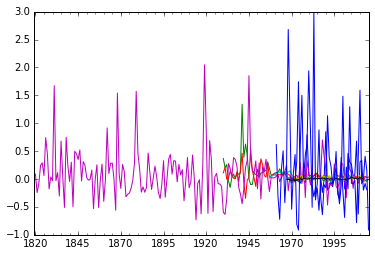

In [1359]:
factors.plot(legend=False)

In [1360]:
factors.describe()

,Natural Resources,R&D Public,R&D Private,# of Doctorates,New Legal Permanent Residents,Post-secondary school enrollment (%),% of doctorates that are STEM,# of IPOs
count,44.000000,86.000000,86.000000,53.000000,194.000000,41.000000,46.000000,55.000000
mean,0.077144,0.075942,0.063558,0.034045,0.089413,0.016399,0.001937,0.228883
std,0.456776,0.179969,0.106668,0.048020,0.396114,0.038405,0.013866,0.817187
min,-0.627033,-0.151000,-0.346000,-0.037334,-0.731879,-0.091116,-0.037829,-0.914286
25%,-0.169686,-0.004750,0.016000,0.002327,-0.101096,-0.000269,-0.004739,-0.295341
50%,-0.049490,0.037000,0.054500,0.019236,0.035091,0.018256,0.003164,0.000000
75%,0.214367,0.098500,0.078750,0.051588,0.270174,0.039843,0.009755,0.499044
max,1.743516,1.340000,0.543000,0.145865,2.046800,0.148377,0.033654,2.977477


# Visualise Data

In [1361]:
# f, axes = plt.subplots(3, 3, sharey=True, figsize=(20,20))
# for factor, ax in zip(factors, axes.ravel()):
#     ax.scatter(factors[factor], patents);
#     ax.set_title(factor)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.xaxis.set_ticks_position('bottom')
#     ax.yaxis.set_ticks_position('left')
#     for tick in ax.get_xticklabels():
#         tick.set_rotation(45)

In [1362]:
best_features = {}
nobs = []
for i in range(1, len(factors)):
    for combo in itertools.combinations(factors.columns, i):
    
        joined = pd.concat([patent_growth, factors[list(combo)]], 1)
        joined = joined.dropna()

        y = joined.pop('Utility Patents')
        X = joined
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0)
        
        X_train = sm.add_constant(X_train)
        model = sm.OLS(y_train, X_train)
        results = model.fit()
        
        nobs.append(results.nobs)
        
        _, _, f, het_pval = het_white(results.resid, results.model.exog)
        
        if het_pval < 0.05:
            results = results.get_robustcov_results()
        
        _, jb_pvalue, _, _ = statsmodels.stats.stattools.jarque_bera(results.resid)
        
        
        if results.f_pvalue < 0.05 and jb_pvalue > 0.05 and np.all(results.pvalues < 0.05):
            best_features[results.rsquared_adj] = (results, X_test, y_test)

/home/jameschristopher/.local/lib/python3.4/site-packages/statsmodels/regression/linear_model.py:1195: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid


### Modeling Patent Growth

For this project we decided to model year over year patent growth, specifically we are looking to model the yearly percent change in total issued patents. For example, in 1950 the total number of patents is 100, and in 1951 the total number of patents is 110, the growth rate is 10%. An example of one of factors we are looking at is government R&D investment, specifically the change in investment year over year. This answers the question: "What percent increase in patents will we see if we increase government R&D investment 10% more than last year?" We will apply this same thinking to other factors we will consider.

Below is the final model we came up with, an OLS linear regression. During the construction of this model we checked for normailty of residuals, and heteroscedasticity. The regression factors yield an F-statistic significant at 0.05, and individual coefficients also significant at 0.05. The model results in an adjusted R-squared of 0.190. The model was trained on a total of 41 observations. The Durbin-Watson statistic indicates little autocorrelation.

In [1363]:
model, oos_x, oos_y = best_features[sorted(best_features)[-1]]
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Utility Patents   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     5.687
Date:                Mon, 12 Dec 2016   Prob (F-statistic):            0.00691
Time:                        03:38:22   Log-Likelihood:                 163.72
No. Observations:                  41   AIC:                            -321.4
Df Residuals:                      38   BIC:                            -316.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------
const                                    0.0246      0.001     18.166      0.000         0.022     0.027
R&D Private                             -0.0793      0.024     -3.241      0.002        -0.129    -0.030
Post-secondary school enrollment (%)    -0.0415      0.020     -2.030      0.049        -0.083    -0.000
==============================================================================
Omnibus:                        1.737   Durbin-Watson:                   2.207
Prob(Omnibus):                  0.420   Jarque-Bera (JB):                1.633
Skew:                           0.397   Prob(JB):                        0.442
Kurtosis:                       2.429   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

/usr/local/lib/python3.4/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


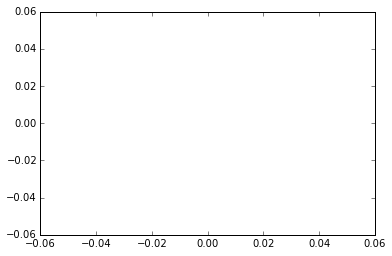

In [1364]:
oos_predictions = model.predict(sm.add_constant(oos_x))
pd.DataFrame({'Predicted': oos_predictions, 'Actual': oos_y})
plt.scatter(oos_predictions, oos_y);
r2_score(oos_y, oos_predictions)

### Train model

In [ ]:
model_factors = sm.add_constant(X_train)
model = sm.OLS(y_train, model_factors)
results = model.fit()

### Are our residuals heteroscedastic?

In [ ]:
_, _, f, pval = het_white(results.resid, model_factors)

In [ ]:
print("P value of the f-stat: %s" % pval)

### ... yes, yes they are heteroscedastic.
### We can use a robust covariance matrix to adjust for this affect.

In [ ]:
results.get_robustcov_results().summary()

### Test model out of sample

In [ ]:
model_test_factors = sm.add_constant(X_test)
oos_predictions = results.predict(model_test_factors)
pd.DataFrame({'Predicted': oos_predictions, 'Actual': y_test})
plt.scatter(oos_predictions, y_test);
r2_score(y_test, oos_predictions)